# Ucitavanje biblioteka

In [1]:
# ucitavanje biblioteka potrebnih za rad
import math
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import random
 
random.seed()

## Bayesova mreza

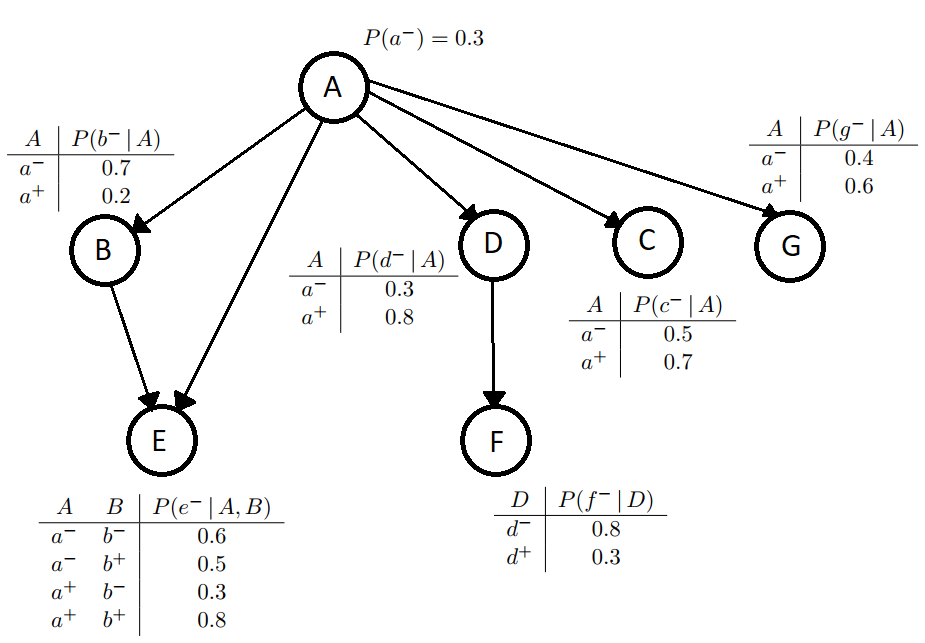

## Globalne promenljive (TUV) i funkcije za Monte Carlo metode estimacije

In [2]:
# broj uzoraka za Monte-Carlo metode
N = 20000
# broj eksperimenata
Nr = 100

# recnici koji predstavljaju TUV
pr_a = 0.3 
pr_b_A = {False: 0.7, True: 0.2}
pr_c_A = {False: 0.5, True: 0.7}
pr_d_A = {False: 0.3, True: 0.8}
pr_g_A = {False: 0.4, True: 0.6}
pr_f_D = {False: 0.8, True: 0.3}
pr_e_A_B = {(False, False): 0.6, (False, True): 0.5, (True, False): 0.3, (True, True): 0.8}

probabilities = {'A': pr_a,
                 'B': pr_b_A,
                 'C': pr_c_A,
                 'D': pr_d_A,
                 'G': pr_g_A,
                 'F': pr_f_D,
                 'E': pr_e_A_B}

# funkcija za uzorkovanje promenljivih sa prosledjenom
# verovatnocom uspeha
def sample(pr=0.5):
    return True if random.random() > pr else False

# funkcija za dohvatanje vrednosti uslovne/apriorne verovatnoce 
# promenljivih
def get_pr(variable_name, variable_value, cond_value_1 = None, cond_value_2 = None):
    
    global probabilities
    
    if cond_value_1 == None and cond_value_2 == None:
        if variable_value:
            pr = 1-probabilities[variable_name]
        else: 
            pr = probabilities[variable_name]
            
        return pr
    
    if cond_value_2 != None:
        index = (cond_value_1, cond_value_2)
    else: 
        index = cond_value_1
        
    if variable_value:
        pr = 1-probabilities[variable_name][index]
    else: 
        pr = probabilities[variable_name][index]
    
    return pr

# funkcija za fitovanje Gausove krive 
# na vektorom ose x sa parametrima mu i sigma
def fit_gauss_curve(x, mu, sigma):
    
    curve = 1/(np.sqrt(2*pi)*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
    
    return curve

## Metod eliminacije

In [3]:
# funkcija za metod eliminacije 
# vraca tacnu verovatnocu P(e-|f+)
def elimination_method():
    pr = 0.6428
    return pr

## Metod uzorkovanja sa odbacivanjem

In [4]:
# funkcija za estimaciju aposteriorne verovatnoce 
# P(e-|f+) Monte-Carlo metodom uzorkovanja sa odbacivanjem
def rejection_sampling(N_samples):
    
    global probabilities
    
    # broj konzistentnih uzoraka -> f = f+
    consistent_samples = 0
    
    # broj povoljnih uzoraka -> e = e- & f = f+
    favorable_samples = 0
    
    while consistent_samples <= N_samples:
        
        a = sample(probabilities['A'])
        
        d = sample(probabilities['D'][a])
        
        f = sample(probabilities['F'][d])
        
        if f:
            consistent_samples += 1
            
            b = sample(probabilities['B'][a])
            
            e = sample(probabilities['E'][(a,b)])
            
            if not e:
                favorable_samples += 1
    
    pr_est = favorable_samples/consistent_samples
    
    return pr_est   

In [5]:
# TESTIRANJE METODA UZORKOVANJA SA ODBACIVANJEM
pr = elimination_method()
pr_est = rejection_sampling(100000)
print('Estimirana aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr_est))
print('Tacna aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr))

Estimirana aposteriorna verovatnoca P(e-|f+) = 0.6441
Tacna aposteriorna verovatnoca P(e-|f+) = 0.6428


## Metoda ponderisanja verodostojnosti

In [6]:
# funkcija za estimaciju aposteriorne verovatnoce 
# P(e-|f+) Monte-Carlo metodom ponderisanjem verodostojnosti
def weighted_likelihood(N_samples):
    
    global probabilities
    
    weight_d_negative = 1 - probabilities['F'][False]
    weight_d_positive = 1 - probabilities['F'][True]
    
    cnt_d_negative = 0
    cnt_d_positive = 0
    
    cnt_e_negative_d_negative = 0
    cnt_e_negative_d_positive = 0
    
    for i in range(N_samples):
        
        # uzorkovanje nedokaznih promeljivih (sve relevantne osim f)
        a = sample(probabilities['A'])
        
        d = sample(probabilities['D'][a])
        
        if d:
            cnt_d_positive += 1
        else:
            cnt_d_negative += 1
        
        b = sample(probabilities['B'][a])
            
        e = sample(probabilities['E'][(a,b)])
        
        if not e and not d:
            cnt_e_negative_d_negative += 1
            
        if not e and d:
            cnt_e_negative_d_positive += 1
        
        
    alpha = 1/(cnt_d_negative*weight_d_negative + cnt_d_positive*weight_d_positive)
    
    pr_est = (cnt_e_negative_d_negative*weight_d_negative + cnt_e_negative_d_positive*weight_d_positive)*alpha
    
    return pr_est

In [7]:
# TESTIRANJE METODA PONDERISANJA VERODOSTOJNOSTI
pr = elimination_method()
pr_est = weighted_likelihood(100000)
print('Estimirana aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr_est))
print('Tacna aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr))

Estimirana aposteriorna verovatnoca P(e-|f+) = 0.6420
Tacna aposteriorna verovatnoca P(e-|f+) = 0.6428


## Gibbsovo uzorkovanje

In [8]:
# funkcija za odredjivanje uslovne verovatnoce
# promenljive A ukoliko se znaju vrednosti promenljivih
# B,C,D,E i G iz prethodne iteracije
def Gibbs_sample_A(b,c,d,e,g):
    
    # P(b|A=a-)
    p_b_a_neg = get_pr('B',b,False)
    
    # P(b|A=a+)
    p_b_a_pos = get_pr('B',b,True)
    
    # P(c|A=a-)
    p_c_a_neg = get_pr('C',c,False)
    
    # P(c|A=a+)
    p_c_a_pos = get_pr('C',c,True)
    
    # P(d|A=a-)
    p_d_a_neg = get_pr('D',d,False)
    
    # P(d|A=a+)
    p_d_a_pos = get_pr('D',d,True)
    
    # P(e|A=a-,B=b)
    p_e_a_neg_b = get_pr('E',e,False,b)
    
    # P(e|A=a+,B=b)
    p_e_a_pos_b = get_pr('E',e,True,b)
    
    # P(g|A=a-)
    p_g_a_neg = get_pr('G',g,False)
    
    # P(g|A=a+)
    p_g_a_pos = get_pr('G',g,True)
    
    # P(A=a-)
    p_a_neg = get_pr('A',False)
    
    # P(A=a+)
    p_a_pos = get_pr('A',True)
    
    p_A_neg = p_b_a_neg * p_c_a_neg * p_d_a_neg * p_e_a_neg_b * p_g_a_neg * p_a_neg
    
    p_A_pos = p_b_a_pos * p_c_a_pos * p_d_a_pos * p_e_a_pos_b * p_g_a_pos * p_a_pos
    
    alpha = 1/(p_A_neg + p_A_pos)
    
    pr = alpha*(p_A_neg)
    
    a = sample(pr)
    
    return a
    
# funkcija za odredjivanje uslovne verovatnoce
# promenljive B ukoliko se znaju promenljiva A iz ove iteracije
# i promenjiva E iz prethodne iteracije
def Gibbs_sample_B(a,e):
        
    # P(e|a,B=b-)
    p_e_b_neg = get_pr('E',e,a,False)
    
    # P(e|a,B=b+)
    p_e_b_pos = get_pr('E',e,a,True)
    
    # P(B=b-|a)
    p_b_neg_a = get_pr('B',False,a) 
    
    # P(B=b+|a)
    p_b_pos_a = get_pr('B',True,a) 
    
    alpha = 1/(p_e_b_neg*p_b_neg_a + p_e_b_pos*p_b_pos_a)
    
    pr = alpha*(p_e_b_neg*p_b_neg_a)
    
    b = sample(pr)
    
    return b

# funkcija za odredjivanje uslovne verovatnoce
# promenljive C ukoliko se zna promenljiva A iz ove iteracije
def Gibbs_sample_C(a):
    
    pr = get_pr('C',False,a)
    
    c = sample(pr)
    
    return c
    
# funkcija za odredjivanje uslovne verovatnoce
# promenljive D ukoliko se znaju promenljiva A iz ove iteracije
# i dokazna promenljiva F koja je fiksirana na f+
def Gibbs_sample_D(a,f):
    
    # P(f+|D=d-)
    p_f_d_neg = get_pr('F',f,False)
    
    # P(D=d-|a)
    p_d_neg_a = get_pr('D',False,a)
    
    # P(f+|D=d+)
    p_f_d_pos = get_pr('F',f,True)
    
    # P(D=d+|a)
    p_d_pos_a = get_pr('D',True,a)
    
    alpha = 1/(p_f_d_neg * p_d_neg_a + p_f_d_pos * p_d_pos_a)
    
    pr = alpha * p_f_d_neg * p_d_neg_a
    
    d = sample(pr)
    
    return d

# funkcija za odredjivanje uslovne verovatnoce
# promenljive E ukoliko se znaju promenljive A i B iz ove iteracije
def Gibbs_sample_E(a,b):
    
    pr = get_pr('E',False,a,b)
    
    e = sample(pr)
    
    return e

# funkcija za odredjivanje uslovne verovatnoce
# promenljive G ukoliko se zna promenljiva A iz ove iteracije
def Gibbs_sample_G(a):
    
    pr = get_pr('G',False,a)
    
    g = sample(pr)
    
    return g
    
# funkcija za estimaciju aposteriorne verovatnoce 
# P(e-|f+) Monte-Carlo metodom Gibbsovog uzorkovanja
def Gibbs_sampling(N_samples):
    
    a = sample()
    b = sample()
    c = sample()
    d = sample()
    e = sample()
    f = True
    g = sample()
    
    favorable_samples = 0
    
    for i in range(N_samples):
        
        a = Gibbs_sample_A(b,c,d,e,g)
        
        b = Gibbs_sample_B(a,e)
        
        c = Gibbs_sample_C(a)
        
        d = Gibbs_sample_D(a,f)
        
        e = Gibbs_sample_E(a,b)
        
        g = Gibbs_sample_G(a)
        
        # f je fiksno, pa nam je povoljno ako je samo E=e-
        if not e:
            favorable_samples += 1
    
    pr_est = favorable_samples/N_samples
    
    return pr_est

In [9]:
# TESTIRANJE METODA GIBSSOVOG UZORKOVANJA
pr = elimination_method()
pr_est = Gibbs_sampling(100000)
print('Estimirana aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr_est))
print('Tacna aposteriorna verovatnoca P(e-|f+) = {:.4f}'.format(pr))

Estimirana aposteriorna verovatnoca P(e-|f+) = 0.6421
Tacna aposteriorna verovatnoca P(e-|f+) = 0.6428


## Simulacija algoritama

In [10]:
estimations = np.zeros((Nr,3), dtype = float)

for i in range(Nr):
    estimations[i,0] = rejection_sampling(N)
    estimations[i,1] = weighted_likelihood(N)
    estimations[i,2] = Gibbs_sampling(N)
    
results = {
    'Metod uzorkovanja sa odbacivanjem': [estimations[:,0], np.mean(estimations[:,0]), np.sqrt(np.var(estimations[:,0]))],
    'Metod ponderisanja verodostojnoscu': [estimations[:,1], np.mean(estimations[:,1]),  np.sqrt(np.var(estimations[:,1]))],
    'Metod Gibbsovog uzorkovanja': [estimations[:,2], np.mean(estimations[:,2]),  np.sqrt(np.var(estimations[:,2]))]
}

for method in results.keys():
    print(method + ': mu = {:.5f}'.format(results[method][1]) + ', sigma = {:.5f}'.format(results[method][2]))

Metod uzorkovanja sa odbacivanjem: mu = 0.64245, sigma = 0.00344
Metod ponderisanja verodostojnoscu: mu = 0.64274, sigma = 0.00379
Metod Gibbsovog uzorkovanja: mu = 0.64284, sigma = 0.00409


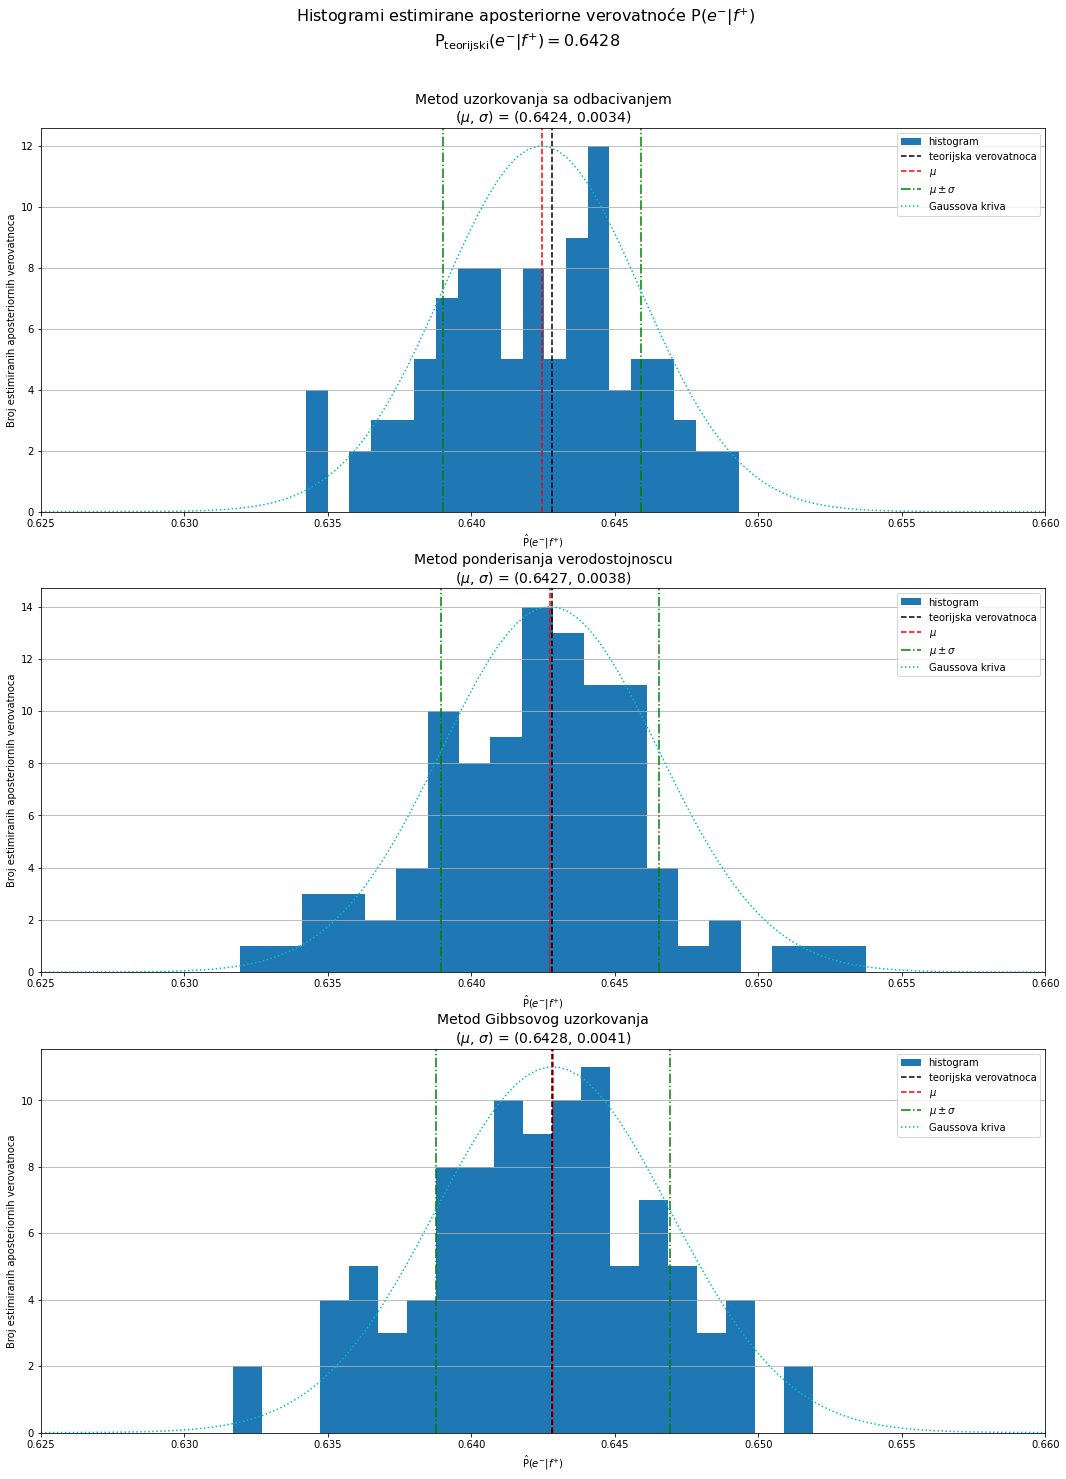

In [11]:
x = np.linspace(0.625, 0.66, 100)
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(18,24))
ax = axes.ravel()

num_of_methods = len(results.keys())

for (i, method) in zip(range(num_of_methods), results.keys()):
    
    # racunanje histograma za svaku od metoda
    hist, bins = np.histogram(results[method][0], bins=20, density=False)
    width = np.amin(bins[1:]-bins[:-1])
    histogram = ax[i].bar(bins[:-1], hist, width=width, label = 'histogram')
     
    # iscrtavanje srednje vrednosti estimacije
    mean = ax[i].axvline(x=results[method][1], color='r', linestyle='--', label = '$\mu$')
    
    # iscrtavanje intervala mu +/- sigma
    std_dev = ax[i].axvline(x = results[method][1] + results[method][2], color='g', linestyle='-.', label = '$\mu \pm \sigma$')
    ax[i].axvline(x = results[method][1] - results[method][2], color='g', linestyle='-.')
    
    # teorijska verovatnoca dobijena metodom eliminacije
    pr = ax[i].axvline(x=elimination_method(), c='k', ls='--', label = 'teorijska verovatnoca')
    
     # fitovanje Gauss-ove raspodele
    gauss = fit_gauss_curve(x, results[method][1], results[method][2])
    gauss_normalized = gauss/np.amax(gauss)*np.amax(hist)
    gauss_plot, = ax[i].plot(x, gauss_normalized, color='c', linestyle=':', label = 'Gaussova kriva')
    
    # X i Y osa grafika
    ax[i].set_xlabel('$\hat{\mathrm{P}}(e^{-}|f^{+})$')
    ax[i].set_ylabel('Broj estimiranih aposteriornih verovatnoca')
    
    # naslov pojedinacnog grafika
    ax[i].set_title(method + '\n($\mu$, $\sigma$) = ({:.4f}, {:.4f})'.format(results[method][1], results[method][2]), fontsize = 14)
    
    ax[i].set_xlim(0.625,0.66)
    ax[i].grid(axis='y')
    
    ax[i].legend(handles=[histogram, pr, mean, std_dev, gauss_plot], loc = 'upper right')
    
fig.suptitle('Histogrami estimirane aposteriorne verovatnoće $\mathrm{P}(e^{-}|f^{+})$ \n$\mathrm{P_{teorijski}}(e^{-}|f^{+}) = $' + str(elimination_method()), fontsize=16, y = 0.95)
plt.show()